## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [ ]:
# Train a network.
# Note: In this example the network is trained within the DeepExplain context.
# However this is not necessary, see `mnist_tensorflow` notebook for an example where DeepExplain
# is used on a pre-trained network.

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax')) 
    # ^ notice that the final softmax must be in its own layer if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # Compute attributions for the first 10 inputs in the test set
    xs = x_test[0:10]
    ys = y_test[0:10]
    input_tensor = model.layers[0].input
    target_tensor = model.layers[-1].input  # < target logits pre-softmax!
    attributions = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
        

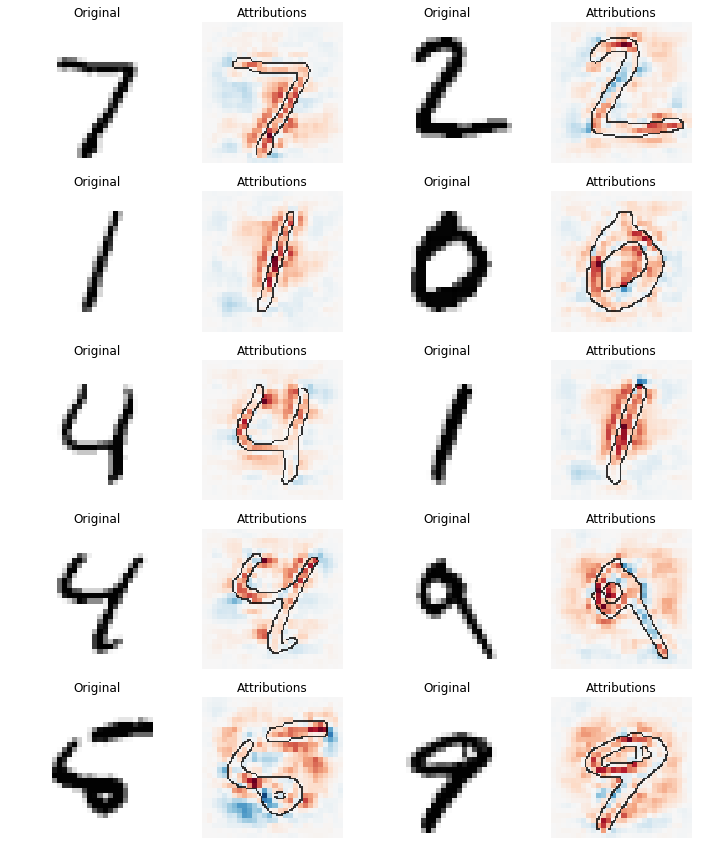

In [6]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

In [ ]:
# Since the model was created within a DeepExplain context, `explain` can be run with different parameters

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    xs = x_test[0:10]
    ys = y_test[0:10]
    input_tensor = model.layers[0].input
    target_tensor = model.layers[-1].input  # < target logits pre-softmax!
    attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)

# Run the previous cell to plot the new attributions